# Modelo General del RIT - David

In [3]:
import pandas as pd
import numpy as np
import utils as ut # esta librería tiene funciones para poder obtener un procesamiento del <T,H>
import spacy

/home/david/anaconda3/envs/rit/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [1]:
def entropia(X):
    """Devuelve el valor de entropia de una muestra de datos""" 
    probs = [np.mean(X == valor) for valor in set(X)]
    return round(sum(-p * np.log2(p) for p in probs), 3)

In [22]:
a=np.array(["0.5","0.5","0.3","0.5","0.5"])
entropia(a)

0.722

In [20]:
b=np.array(["0.3","0.3","0.3","0.2","0.2"])
entropia(b)

0.971

In [23]:
(0.722+0.971)/2

0.8465

In [21]:
c=np.array(["0.5","0.5","0.3","0.5","0.5","0.3","0.3","0.3","0.2","0.2"])
entropia(c)

1.522

## Empezaremos con cargar los words embeddings de GLOVE
### Se pueden cambiar por los que sean necesarios

In [2]:
nlp = spacy.load("en_core_web_md") # modelo de nlp

In [4]:
ut.load_vectors_in_lang(nlp,"data/glove.840B.300d.txt") # carga de vectores en nlp.wv

## Lectura de los pares <T,H> para realizar las pruebas
### se cargará la información de los textos e hipótesis en listas

In [5]:
prueba=pd.read_csv("data/pruebaDEV.csv")  # archivo donde se tiene almacenado la información de los pares <T,H>
prueba

,Unnamed: 0,gold_label,sentence1,sentence2,SET
0,549859,neutral,Nine women in white robes with hoods walk on p...,The women are wearing flip flops.,DEV
1,556575,neutral,A woman dressed in a blue tennis outfit is ret...,A woman is in the Olympics.,DEV
2,558921,entailment,A female figure skater in costume is executing...,A skater is on the ice.,DEV
3,557492,neutral,Young people in uniform are playing in a rugby...,One person is kicking the rugby ball down the ...,DEV
4,556286,contradiction,a big tan dog drinks water from an outdoor wat...,A dog is chasing a cat.,DEV
...,...,...,...,...,...
2095,558386,contradiction,Elderly woman with green sweater picking out p...,The elderly lady is dead in a coffin,DEV
2096,550734,contradiction,Two little girls and one little boy are runnin...,The kids are sitting down.,DEV
2097,551119,contradiction,Several people wait to checkout inside a store...,an elevator being serviced,DEV
2098,558908,neutral,A large black and white dog is catching a Fris...,The people at the park are not impressed with ...,DEV


In [6]:
textos = prueba["sentence1"].to_list()       # almacenamiento en listas
hipotesis = prueba["sentence2"].to_list()
print(textos)
print(hipotesis)

['Nine women in white robes with hoods walk on plush, green grass.', 'A woman dressed in a blue tennis outfit is returning a hit with her tennis racket', 'A female figure skater in costume is executing a routine.', 'Young people in uniform are playing in a rugby game.', 'a big tan dog drinks water from an outdoor water spout.', 'Three people and a white dog are sitting in the sand on a beach.', 'Young man walking dog', 'Two indian men are dancing in suits with an indian woman in a colorful dress behind them by a brick wall.', 'Two women stand on a beach and perform stretches or yoga together, facing towards the water and away from the camera.', 'A woman in glittery face-paint and a sequined cap parades with several similarly-dressed individuals in shades of orange and brown.', 'A local policeman standing in front of the counter with complete equipments belted to his waist.', 'Group of people stand near a fence watching a plane fly over them', 'A man in a red shirt plays his guitar whil

## Procesamiento de todos los pares:
### Limpieza de los textos (eliminación de puntuación)
### Obtener su representación de embeddings normalizada
### Obtener su representación de embeddings no normalizada (esto para el calculo de la distancia euclideana)
### Generar matriz de producto puntos de vectores

In [7]:
import mutual_info as mi

from scipy.stats import wasserstein_distance

import conceptnet_lite
conceptnet_lite.connect("data/conceptnet.db")
from conceptnet_lite import Label, edges_for

In [8]:
## esta función revisa hiperonimia, sinonimia entre otras.
def encontrar_relaciones(relaciones):
    borrar=set()
    borrar_i=set()
    for r in relaciones:
        index=r[0]
        c=r[1]
        wt=str(index).split("{")[1].split(",")[0]
        wh=str(c).split("{")[1].split(",")[0]    
        try:
            for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                if "synonym"==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    else:
                        if e.start.text==wt:
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                elif "is_a" ==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," is_a ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    else: ##quitar y la busqueda de relacioens
                        if wh== e.end.text:
                            if e.start.text==wt:
                                print(wt," is_a ",wh)
                                borrar.add(c)
                                borrar_i.add(index)
                                break
                # elif "derived_from" == e.relation.name:
                #     if wh== e.start.text:
                #         if e.end.text==wt:
                #             print(wh," derivado_from ",wt)
                #             borrar.add(c)
                #             borrar_i.add(index)
                #             break
                elif "used_for" == e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," used_for ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
        except:
            a=0
    return list(borrar),list(borrar_i)

In [9]:
def encontrar_relaciones_contrarias(relaciones):
    antonyms=[]
    borrar=[]
    borrar_i=[]
    for r in relaciones:
        index=r[0]
        c=r[1]
        wt=str(index).split("{")[1].split(",")[0]
        wh=str(c).split("{")[1].split(",")[0]
        try:
            for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                if "antonym" ==e.relation.name:
                    if wt== e.start.text:
                        if e.end.text==wh:
                            print(wt," antonym ",wh)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
                        else:
                            print(wh," antonym ",wt)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
                elif "distinct_from" ==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," distinct from ",wt)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
                    else:
                        if e.start.text==wt:
                            print(wt," antonym ",wh)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
        except:
            a=0
    return borrar,borrar_i,antonyms

In [10]:
def encontrar_relaciones_cercanas(indexes,columnas):
    borrar=[]
    borrar_i=[]
    related=[]
    for index in indexes:
        for c in columnas:
            wt=str(index).split("{")[1].split(",")[0]
            wh=str(c).split("{")[1].split(",")[0]
            try:
                for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                    if "related_to" ==e.relation.name:
                        if wt== e.start.text:
                            if e.end.text==wh:
                                print(wt," related_to ",wh)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
                            else:
                                print(wh," related_to ",wt)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
                    elif "similar_to" ==e.relation.name:
                        if wh== e.start.text:
                            if e.end.text==wt:
                                print(wh," similar_to ",wt)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
                        else:
                            if e.start.text==wt:
                                print(wt," similar_to ",wh)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
            except:
                a=0
    return borrar,borrar_i,related

In [11]:
def obtener_distancia(texto_v,hipotesis_v,texto_t,texto_h):
    lista_l=[]
    for i in range(len(texto_t)):
        lista=[]
        for j in range(len(texto_h)):
            lista.append(np.linalg.norm(texto_v[i] - hipotesis_v[j]))#*wasserstein_distance(texto_2[i],hipotesis_2[j]))
        lista_l.append(lista)
    df_distEuc=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    col=df_distEuc.columns
    borrar=[]
    for c in col:
        if "{null" in str(c) or "{be,VERB" in str(c) or ("NOUN" not in str(c) and "VERB" not in str(c) and "ADJ" not in str(c) and "ADV" not in str(c)):
            borrar.append(c)        
    borrar_i=[]
    indexes=df_distEuc.index
    for index in indexes:
        if "{null" in str(index) or "{be,VERB" in str(index) or ("NOUN" not in str(index) and "VERB" not in str(index) and "ADJ" not in str(index) and "ADV" not in str(index)):
            borrar_i.append(index)        
    df_distEuc=df_distEuc.drop(borrar,axis=1)
    df_distEuc=df_distEuc.drop(borrar_i,axis=0)
    return df_distEuc.min().sum()

In [12]:
def wasserstein_mutual_inf(texto_v,hipotesis_v,texto_t,texto_h):  
    lista_l=[]
    lista_muinfor=[]   
    for i in range(len(texto_t)):
        lista=[]
        lista_mu=[]
        for j in range(len(texto_h)):
            lista.append(wasserstein_distance(texto_v[i],hipotesis_v[j]))
            lista_mu.append(mi.mutual_information_2d(np.array(texto_v[i]),np.array(hipotesis_v[j])))
        lista_l.append(lista)
        lista_muinfor.append(lista_mu)
    DFmearth=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    DFmutual_inf=pd.DataFrame(lista_muinfor,index=texto_t,columns=texto_h)
    return DFmearth,DFmutual_inf

In [13]:
def entropia(X):
    print(X)
    """Devuelve el valor de entropia de una muestra de datos""" 
    probs = [np.mean(X == valor) for valor in set(X)]
    return round(sum(-p * np.log2(p) for p in probs), 3)

In [14]:
import time

# Proceso principal

In [15]:
sumas=[]
distancias=[]
entropias=[]
etiquetas=[]
mearts=[]
mutinf=[]
max_info=[]
list_antonimos=[]
listas_malign=[]
lista_anto=[]
lista_related=[]
lista_relatedT=[]
diferencias=[]

inicio = time.time()
corte=10
contador=0
#for i in range(len(textos)):
for i in range(5):
    print(i)

    t_vectors=ut.get_matrix_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=False,lemmatize=False)
    h_vectors=ut.get_matrix_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=False,lemmatize=False)
    t_vectors_n=ut.get_matrix_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    h_vectors_n=ut.get_matrix_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    t_clean=ut.get_words_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    h_clean=ut.get_words_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)


    # Obtencion de matriz de alineamiento, matriz de move earth y mutual information
    ma=np.dot(t_vectors_n,h_vectors_n.T)
    #print(len(t_vectors_n),len(h_vectors_n),len(t_clean),len(h_clean))
    m_earth,m_mi=wasserstein_mutual_inf(t_vectors_n,h_vectors_n,t_clean,h_clean)
    ma=pd.DataFrame(ma,index=t_clean,columns=h_clean)

    ###### BORRADO DE COSAS QUE NO OCUPO, SOLO NOS QUEDAMOS CON INFORMACIÓN DE TIPOS DE PALABRA: NOUN, VERB, ADJ Y ADV
    # TAMBIÉN OMITIMOS EL VERBO BE DEBIDO A QUE POR LO REGULAR SE UTILIZA COMO AUXILIAR Y ES UN VERBO COPULATIVO
    # sirve para construir la llamada predicación nominal del sujeto de una oración: 
    # #el sujeto se une con este verbo a un complemento obligatorio llamado atributo que por lo general determina 
    # alguna propiedad, estado o equivalencia del mismo, por ejemplo: "Este plato es bueno". "Juan está casado". 

    col=ma.columns
    borrar=[]
    indexes=ma.index
    for c in col:
        if "{null," in str(c) or "{be,VERB" in str(c) or ("NOUN" not in str(c) and "VERB" not in str(c) and "ADJ" not in str(c) and "ADV" not in str(c)):
            borrar.append(c)        
        elif str(c) in indexes:
            borrar.append(c)        
    borrar_i=[]
    for index in indexes:
        if "{null," in str(index) or "{be,VERB" in str(index) or ("NOUN" not in str(index) and "VERB" not in str(index) and "ADJ" not in str(index) and "ADV" not in str(index)):
            borrar_i.append(index) 
        elif str(index) in col:
            borrar_i.append(index) 
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    # ELIMINAMOS INFORMACIÓN DONDE SE CORRESPONDAN EN LEMMAS, TENGA UN PRODUCTO IGUAL A 1 Y SEAN IGUALES LOS INDICES Y COLUMNAS
    # SI EL VALOR ES IGUAL A 1 SIGNIFICA QUE ES LA MISMA PALABRA, O SON SINONIMOS
    borrar=[]
    borrar_i=[]
    col=ma.columns
    for index,strings in ma.iterrows():
        lema_i=str(index).split("{")[1].split(",")[0]
        lon=0
        for c in col:
            if index==c:
                borrar_i.append(index)
                borrar.append(c)
            # print(strings[lon])
            # if strings[lon]>=1:
            #     print("entro",lon,c)
            #     borrar_i.append(index)
            #     borrar.append(c)
            lema_c=str(c).split("{")[1].split(",")[0]
            if lema_i == lema_c:
                borrar_i.append(index)
                borrar.append(c)
            lon+=1
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
    
    #primera vuelta ---------------------------------------------------------------------------------
    # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET
    d=[]
    d1=[]
    pasada=0
    while len(ma.index)>0 and len(ma.columns)>0 and pasada<2:
        a=ma.idxmax().values
        b=ma.columns
        rel=[]
        for j in range(len(a)):
            rel.append((a[j],b[j]))
        borrar,borrar_i=encontrar_relaciones(rel[:])
        ma=ma.drop(borrar,axis=1)
        ma=ma.drop(borrar_i,axis=0)
        m_earth=m_earth.drop(borrar,axis=1)
        m_earth=m_earth.drop(borrar_i,axis=0)
        m_mi=m_mi.drop(borrar,axis=1)
        m_mi=m_mi.drop(borrar_i,axis=0)

        # relaciones contrarias
        #PARA REVISAR SI EXISTEN RELACIONES CONTRARIAS A TRAVÉS DEL USO DE CONCEPNET
        a=ma.idxmax().values
        b=ma.columns
        rel=[]
        for j in range(len(a)):
            rel.append((a[j],b[j]))
        if pasada==0:
            borrar,borrar_i,d=encontrar_relaciones_contrarias(rel[:])
        else:
            borrar,borrar_i,d1=encontrar_relaciones_contrarias(rel[:])
        ma=ma.drop(borrar,axis=1)
        ma=ma.drop(borrar_i,axis=0)
        m_earth=m_earth.drop(borrar,axis=1)
        m_earth=m_earth.drop(borrar_i,axis=0)
        m_mi=m_mi.drop(borrar,axis=1)
        m_mi=m_mi.drop(borrar_i,axis=0)

        # # segunda vuelta--------------------------------------------------------------------------------------------
        # # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET
        # a=ma.idxmax().values
        # b=ma.columns
        # rel=[]
        # for i in range(len(a)):
        #     rel.append((a[i],b[i]))
        # borrar,borrar_i=encontrar_relaciones(rel[:])
        # ma=ma.drop(borrar,axis=1)
        # ma=ma.drop(borrar_i,axis=0)
        # m_earth=m_earth.drop(borrar,axis=1)
        # m_earth=m_earth.drop(borrar_i,axis=0)
        # m_mi=m_mi.drop(borrar,axis=1)
        # m_mi=m_mi.drop(borrar_i,axis=0)
            
        # #relaciones contrarias quitar
        # a=ma.idxmax().values
        # b=ma.columns
        # rel=[]
        # for i in range(len(a)):
        #     rel.append((a[i],b[i]))
        
        # borrar,borrar_i,d1=encontrar_relaciones_contrarias(rel[:])
        # ma=ma.drop(borrar,axis=1)
        # ma=ma.drop(borrar_i,axis=0)
        # m_earth=m_earth.drop(borrar,axis=1)
        # m_earth=m_earth.drop(borrar_i,axis=0)
        # m_mi=m_mi.drop(borrar,axis=1)
        # m_mi=m_mi.drop(borrar_i,axis=0)
        pasada+=1

    # ultima VUELTA PARA CHECAR RELACIONES CERCANAS --------------------------------------------------
    # relaciones cercanas quitar
    r_l2=[]
    if len(ma.index)>0 and len(ma.columns)>0:
        indexes=ma.index
        columnas=ma.columns
        borrar,borrar_i,r_l2=encontrar_relaciones_cercanas(indexes,columnas)
        ma=ma.drop(borrar,axis=1)
        ma=ma.drop(borrar_i,axis=0)
        m_earth=m_earth.drop(borrar,axis=1)
        m_earth=m_earth.drop(borrar_i,axis=0)
        m_mi=m_mi.drop(borrar,axis=1)
        m_mi=m_mi.drop(borrar_i,axis=0)
    
    #print(ma.index,ma.columns)
        
    #   ALMACENAMIENTO DE TODA LA INFORMACIÓN PROCESADA
    #alamacenado de resultados
    sumas.append(ma.min().sum())
    max_info.append((ma.max().sum()/(ma.shape[1])))
    entropias.append(entropia(ma.round(2).values.flatten()))
    mearts.append(m_earth.max().sum())
    mutinf.append(m_mi.max().sum())
    distancias.append(obtener_distancia(t_vectors,h_vectors,t_clean,h_clean)) 
    if len(ma.columns)==0:
        diferencias.append(1)
    elif len(ma.columns)>0 and len(ma.index)==0:
        diferencias.append(0.5)
    elif len(ma.columns)>0 and len(ma.index)>0:
        diferencias.append(len(ma.columns)/len(ma.index))
    
    d2=[]   
    if d==[] and d1==[]:
        d2=[]
    else:
        d2=list(set(d+d1))
    r2=[]   
    if r_l2==[]:
        r2=[]
    else:
        r2=list(set(r_l2))
    list_antonimos.append(len(d2))
    listas_malign.append(ma)
    lista_anto.append(d2)
    lista_related.append(len(r2))
    lista_relatedT.append(r2)
    print(i,corte)
    if i==corte:
        clases=prueba["gold_label"].values
        temp1 =np.array([sumas,distancias,entropias,mutinf,mearts,max_info,list_antonimos,lista_related,diferencias,clases[:i+1]])
        df_resultados = pd.DataFrame(temp1.T,columns=["suma","distancias","entropias","mutual_info","m_earth","max_info_p","antonimos","relaciones","diferencias","CLASS"])
        df_resultados.to_csv("salida/resultadoMRITDEV"+str(i)+".csv",index=False)
        print("guardado",corte)
        corte+=10

fin = time.time()
print("Tiempo que se llevo:",round(fin-inicio,2)," segundos")
df_resultados.to_csv("salida/resultadoMRITDEV_FINAL.csv",index=False)

0
[0.54 0.12 0.12 0.37 0.08 0.08 0.35 0.24 0.24 0.25 0.29 0.29 0.24 0.25
 0.25 0.4  0.13 0.13 0.23 0.07 0.07]
0 10
1
[0.08 0.   0.3  0.09 0.23 0.07 0.3  0.14]
1 10
2
figure  related_to  ice
[ 0.02  0.11  0.09 -0.01  0.13]
2 10
3
ball  used_for  game
people  antonym  person
people  antonym  person
people  related_to  person
[0.32 0.22 0.19 0.67 0.26 0.18 0.29 0.27 0.38 0.25 0.61 0.38]
3 10
4
[ 0.12  0.16  0.24  0.09  0.12  0.1   0.24  0.09 -0.01  0.08]
4 10
Tiempo que se llevo: 35.48  segundos


NameError: name 'df_resultados' is not defined

In [19]:
len(sumas)

11

In [25]:
print(listas_malign[0].shape)

(0, 1)


In [26]:
distancias[0]

66.55827

In [ ]:
clases=prueba["gold_label"].values
temp1 =np.array([sumas,distancias,entropias,mutinf,mearts,max_info,list_antonimos,lista_related,clases])
df_resultados = pd.DataFrame(temp1.T,columns=["suma","distancias","entropias","mutual_info","m_earth","max_info_p","antonimos","relaciones","CLASS"])
df_resultados

,suma,distancias,entropias,mutual_info,m_earth,max_info_p,antonimos,relaciones,CLASS
0,-0.264991,294.031952,4.839,9.576863,0.037193,0.517302,0,1,entailment
1,0.103484,189.135696,2.585,1.784762,0.006869,0.251793,0,1,entailment
2,-0.009624,123.245392,3.948,3.902809,0.017327,0.289142,0,0,contradiction
3,0.0,0.0,0,0.0,0.0,NaN,0,0,contradiction
4,0.176506,113.819,2.75,3.763009,0.011833,0.373197,0,0,neutral
...,...,...,...,...,...,...,...,...,...
95,-0.080292,247.618469,4.438,7.502547,0.03523,0.464188,0,1,entailment
96,0.0,37.524601,0,0.0,0.0,NaN,0,0,entailment
97,0.160267,189.692383,3.64,5.416953,0.026852,0.316492,0,1,contradiction
98,0.291853,97.558205,2.0,3.77399,0.010269,0.363122,0,1,contradiction


In [ ]:
df_resultados.to_csv("salida/resultadoMRITDEV.csv",index=False)

<Axes: title={'center': 'distancias'}, xlabel='CLASS'>

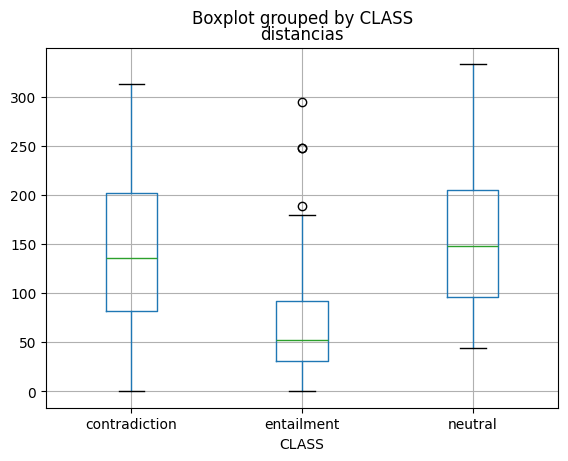

In [ ]:
df_resultados.boxplot(by="CLASS",column=["distancias"])

array([<Axes: title={'center': 'suma'}, xlabel='CLASS'>,
       <Axes: title={'center': 'entropias'}, xlabel='CLASS'>],
      dtype=object)

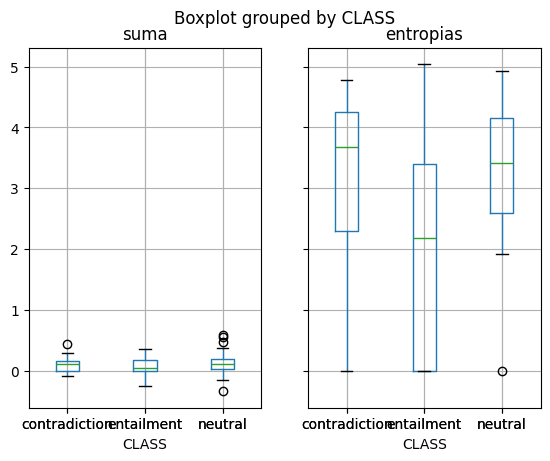

In [ ]:
df_resultados.boxplot(by="CLASS",column=["suma","entropias"])

array([[<Axes: title={'center': 'mutual_info'}, xlabel='CLASS'>,
        <Axes: title={'center': 'm_earth'}, xlabel='CLASS'>],
       [<Axes: title={'center': 'max_info_p'}, xlabel='CLASS'>, <Axes: >]],
      dtype=object)

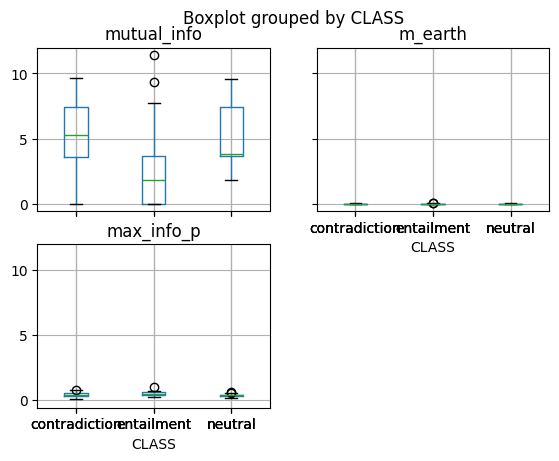

In [ ]:
df_resultados.boxplot(by="CLASS",column=["mutual_info","m_earth","max_info_p"])

array([<Axes: title={'center': 'antonimos'}, xlabel='CLASS'>,
       <Axes: title={'center': 'relaciones'}, xlabel='CLASS'>],
      dtype=object)

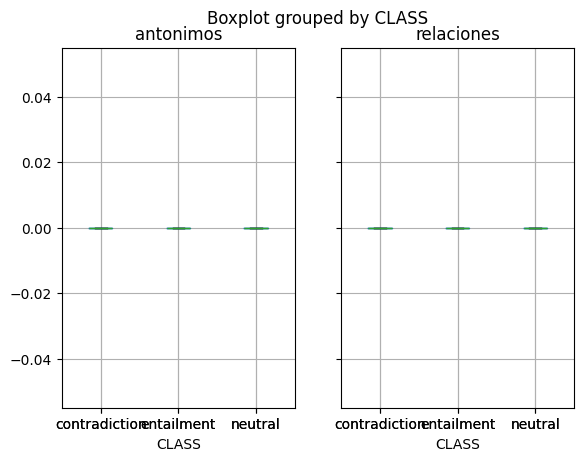

In [ ]:
df_resultados.boxplot(by="CLASS",column=["antonimos","relaciones"])